In [0]:
from google.colab import drive
import sys
drive.mount("/content/drive")
sys.path.append("/content/drive/My Drive/SH")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path

import itertools
from functools import partial

from clothoids import lookup_clothoid_parameters, lookup_clothoid_parameters_from_points, angle_between

DATA_DIR = Path("/content/drive/My Drive/SH/report/data")

NUM_SUBGOALS = 2

tf.keras.backend.clear_session()
tf.__version__

'2.2.0-rc3'

In [0]:
"""Sampling techniques for gradient-free agents.
"""

import itertools
import tensorflow as tf
from abc import ABC, abstractmethod
import typing

def scale_to_length(x: tf.Tensor, length: float) -> tf.Tensor:
    """Utility function to scale vector(s) to a certain length.

    Arguments:
        x {tf.Tensor} -- the vector (or collection of vectors in form of a matrix)
        length {float} -- the length

    Returns:
        tf.Tensor -- the scaled vector(s)
    """

    magnitude = tf.norm(x, axis=-1, keepdims=True)
    return (length / magnitude) * x


class SamplingTechnique(ABC):
    """Abstract base class representing a sampling technique (for weight space).
    """

    @abstractmethod
    def initialize(self, num_weights: int):
        """Initialize the sampling technique.

        This method should be called once before training. 
        Its purpose is to pre-compute certain values such that they do not have to be computed over and over again during training.

        Arguments:
            num_weights {int} -- the dimensionality of the weight space
        """

    @abstractmethod
    def __call__(self, weights: tf.Tensor) -> typing.Union[tf.Tensor, typing.Iterator[tf.Tensor]]:
        """Obtain a sample given the current weight state.

        Arguments:
            weights {tf.Tensor} -- the current weight state

        Returns:
            typing.Union[tf.Tensor, typing.Iterator[tf.Tensor]] -- depending on the type of sampling technique, this will be a tensor of all weight samples or a generator to arbitrarily generate weight samples for computational efficiency.
        """


class ExhaustiveSamplingTechnique(SamplingTechnique):
    """Implementation of an exhaustive sampling technique that obtains samples with a specific radius along all possible 45° directions in a weight space of arbitrary dimensionality.

    The number of samples will be 3^N-1 where N is the dimensionality of the weight space.
    """

    def __init__(self, sample_radius: float, uniform_radius: bool = True):
        """Constructor.

        Arguments:
            sample_radius {float} -- the sample radius

        Keyword Arguments:
            uniform_radius {bool} -- whether or not to ensure that all samples have the same length (if False, the samples at 45° angles will be longer than the ones at 90° angles to any weight axis) (default: {True})
        """
        self.sample_radius = sample_radius
        self.uniform_radius = uniform_radius

    def initialize(self, num_weights: int):
        # We will use this method to pre-compute the weight changes, so they can just be added to the current weight state to get the samples later

        # First, we will get all combinations of [-1,0,1] of dimensionality N (number of weight)
        weight_changes = itertools.product([-1, 0, 1], repeat=num_weights)

        # Remove the entry with all zeros (that would just be the current weight state)
        weight_changes = filter(lambda x: not all(
            map(int(0).__eq__, x)), weight_changes)

        # Convert to TensorFlow constant
        weight_changes = tf.constant(list(weight_changes), dtype=tf.float32)

        # Scale weight changes
        if self.uniform_radius:
            weight_changes = scale_to_length(
                weight_changes, self.sample_radius)
        else:
            weight_changes *= self.sample_radius
        self.weight_changes = weight_changes

    def __call__(self, weights: tf.Tensor) -> tf.Tensor:
        # Return the samples
        return weights + self.weight_changes


class RandomSamplingTechnique(SamplingTechnique):
    """Implementation of a random sampling technique that obtains samples within a specific radius in a weight space of arbitrary dimensionality.
    """

    def __init__(self, sample_radius: float, num_samples: int, uniform_radius: bool = True):
        """Constructor.

        Arguments:
            sample_radius {float} -- the sample radius
            num_samples {int} -- the number of random samples to generate

        Keyword Arguments:
            uniform_radius {bool} -- whether the samples should be along the circumference of the sampling circle (True) or in the area of the sampling circle (False) (default: {True})
        """
        self.sample_radius = sample_radius
        self.num_samples = num_samples
        self.uniform_radius = uniform_radius

    def initialize(self, num_weights: int):
        # Remember the number of weights
        self.num_weights = num_weights

    def __call__(self, weights: tf.Tensor) -> tf.Tensor:
        # Get random samples in the interval (0, 1]
        weight_changes = 1 - \
            tf.random.uniform(
                shape=(self.num_samples, self.num_weights), minval=0, maxval=1, dtype=tf.float32)

        # Make some of these samples negative, so we get the range [-1,1], but excluding 0
        sign = tf.sign(weight_changes - 0.5)
        weight_changes *= tf.where(sign != 0., sign, 1.)

        # Scale the samples
        if self.uniform_radius:
            weight_changes = scale_to_length(
                weight_changes, self.sample_radius)
        else:
            weight_changes *= self.sample_radius
        return weights + weight_changes


class RandomSamplingGenerator(SamplingTechnique):
    """Similar to RandomSamplingTechnique, except that samples are obtained on-demand using a generator.

    This should be used when the number of samples needed is not known beforehand, and each sample is processed separately until reaching a termination condition.
    """

    def __init__(self, sample_radius: float, uniform_radius: bool = True):
        """Constructor.

        Arguments:
            sample_radius {float} -- the sample radius
            num_samples {int} -- the number of random samples to generate

        Keyword Arguments:
            uniform_radius {bool} -- whether the samples should be along the circumference of the sampling circle (True) or in the area of the sampling circle (False) (default: {True})
        """
        self.sample_radius = sample_radius
        self.uniform_radius = uniform_radius

    def initialize(self, num_weights: int):
        # Record the number of weights
        self.num_weights = num_weights

    def __call__(self, weights: tf.Tensor) -> tf.Tensor:
        # Generator loop
        while True:

            # Get random samples in the interval (0, 1]
            weight_changes = 1 - tf.random.uniform(shape=(self.num_weights,),
                                                   minval=0, maxval=1, dtype=tf.float32)
            # Make some of these samples negative, so we get the range [-1,1], but excluding 0
            sign = tf.sign(weight_changes - 0.5)
            weight_changes *= tf.where(sign == 0., 1., sign)

            # Scale the samples
            if self.uniform_radius:
                weight_changes = scale_to_length(
                    weight_changes, self.sample_radius)
            else:
                weight_changes *= self.sample_radius

            # Yield on demand
            yield weights + weight_changes


In [0]:
# Radial basis activation function: e^(-x^2)
@tf.function
def rbf(x):
    return tf.exp(-tf.pow(x, 2))

# Define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,
                          use_bias=False,
                          input_shape=(2,),
                          activation=rbf)
])

initial_weights = np.array([1, 1])[:, np.newaxis].astype(np.float32)
model.weights[0].assign(tf.constant(initial_weights))
model.get_weights()

[array([[1.],
        [1.]], dtype=float32)]

In [0]:
model.compile(loss="mse", optimizer="sgd", metrics=["accuracy"])

In [0]:
y = np.array([
    1,
    rbf(2.),
    rbf(2.)
])
X = np.array([
    (2, 2),
    (2, 0),
    (0, 2)
])
X, y

(array([[2, 2],
        [2, 0],
        [0, 2]]), array([1.        , 0.01831564, 0.01831564]))

In [0]:
def compute_subgoals(initial, goal, N, model, x):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        if WEIGHTS_SHAPE is None:
            get_weights()

        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, x):
        set_weights(weights)
        return model.predict(x)

    subgoal_weights = tf.expand_dims(tf.linspace(0., 1, N), axis=-1) * (goal - initial) + initial

    subgoals = tf.stack([predict_for_weights(weights, x) for weights in subgoal_weights])
    subgoals = tf.squeeze(subgoals)
    
    return subgoal_weights, subgoals


initial = tf.constant([1., 1])
goal = tf.constant([1., -1])
N = NUM_SUBGOALS + 1 # number of subgoals

weights, subgoals = compute_subgoals(initial, goal, N, model, X)

subgoals

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.12535176e-07, 1.83156393e-02, 1.83156393e-02],
       [1.83156393e-02, 1.83156393e-02, 1.00000000e+00],
       [1.00000000e+00, 1.83156393e-02, 1.83156393e-02]], dtype=float32)>

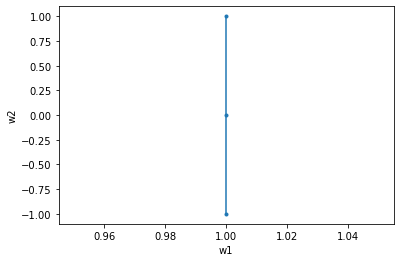

In [0]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

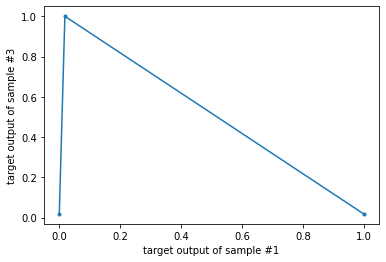

In [0]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #1")
ax.set_ylabel("target output of sample #3")
ax.plot(subgoals[..., 0], subgoals[..., 2], '.-')

In [0]:
initial_weights = [1, 1]
model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))

training_weights = []
predictions = []
num_epochs = []

def train(model, subgoal, X, learning_rate):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    #sampler = RandomSamplingTechnique(learning_rate, 6, uniform_radius=True)
    sampler = ExhaustiveSamplingTechnique(learning_rate, uniform_radius=True)
    sampler.initialize(tf.reduce_sum(tf.reduce_prod(WEIGHTS_SHAPE, axis=-1)))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, X):
        set_weights(weights)
        return tf.squeeze(model.predict(X))
    
    def calculate_thetas(start, samples, goal):
        # start: (N,)
        # samples: (B, N)
        # goal: (N,)
        start = np.expand_dims(start, axis=0)
        goal = np.expand_dims(goal, axis=0)

        start = np.broadcast_to(start, samples.shape)
        goal = np.broadcast_to(goal, samples.shape)

        gamma1, gamma2, alpha, beta, t1, t2 = lookup_clothoid_parameters_from_points(goal, samples, start)
        return alpha + beta
    
    predict_fn = partial(predict_for_weights, X=X)

    # 0. Initialise
    start = predict_fn(get_weights()).numpy()
    goal = subgoal.numpy()
    theta = 0. 
    
    training_weights.append(get_weights())
    predictions.append(start)

    i = 0
    while True:

        # 1. Make an initial move in weight and output space
        curr_weights = get_weights()
        weight_samples = sampler(curr_weights).numpy()
        output_samples = tf.map_fn(predict_fn, weight_samples).numpy()

        # Just to be sure, check if any of the samples is the goal
        if np.any(np.all(output_samples == goal, axis=-1)):
            # Find sample
            best_index = np.argmax(np.all(output_samples == goal, axis=-1))
        
        else:

            # Discard output samples that are equal to current point
            mask = ~np.all(output_samples == start, axis=-1)
            #mask = np.linalg.norm(output_samples - start, axis=-1) > 0.01

            # Only pick the ones that make progress
            #mask &= np.linalg.norm(output_samples - goal, axis=-1) <= np.linalg.norm(start - goal)

            if np.all(~mask):
                mask = ~np.all(output_samples == start, axis=-1)

            output_samples = output_samples[mask, :]
            weight_samples = weight_samples[mask, :]

            candidate_thetas = calculate_thetas(start, output_samples, goal)
            cost = np.abs(candidate_thetas - theta)

            best_index = np.argmin(cost)

        set_weights(weight_samples[best_index])

        training_weights.append(weight_samples[best_index])
        predictions.append(output_samples[best_index])

        # Update values
        theta = candidate_thetas[best_index]
        start = output_samples[best_index]

        print(theta, start)

        if tf.norm(output_samples[best_index] - subgoal) <= .01 * tf.norm(start - subgoal):
            print(subgoal, output_samples[best_index])
            num_epochs.append(i)
            break

        i+=1

        if i == 100:
            break
    return i

for i, subgoal in enumerate(subgoals[1:], 1):
    print(f"Attempting to achieve subgoal {i}: {subgoal}")
    print(train(model, subgoal, X, learning_rate=.1))

Attempting to achieve subgoal 1: [0.01831564 0.01831564 1.        ]
0.028785200216726488 [5.3553504e-07 1.8315639e-02 3.9163906e-02]
0.03028028951134936 [2.3525772e-06 1.8315639e-02 7.7304766e-02]
0.033384019186262666 [9.5401674e-06 1.8315639e-02 1.4085849e-01]
0.036639150308732736 [3.5712892e-05 1.8315639e-02 2.3692785e-01]
0.04543935944796863 [1.2340992e-04 1.8315639e-02 3.6787960e-01]
0.061487912888983795 [3.9366973e-04 1.8315639e-02 5.2729255e-01]
0.09540183714169508 [0.00115923 0.01831564 0.6976765 ]
0.17806702750767886 [0.00315111 0.01831564 0.8521438 ]
0.5090116666857827 [0.00790706 0.01831564 0.9607895 ]
3.16582319359252 [0.00315111 0.00790705 0.9607895 ]
3.0888923330527485 [0.00115923 0.00315111 0.9607895 ]
3.1195511261829894 [0.00465777 0.00608957 0.99657446]
2.7761158675814537 [0.01594778 0.01130675 0.99316055]
4.324101042944467 [0.01594778 0.02017052 0.99657446]
4.712388980384689 [0.04653018 0.03457201 0.99316055]
4.712388980384689 [0.11568645 0.05693253 0.9509494 ]
4.71238

KeyboardInterrupt: ignored

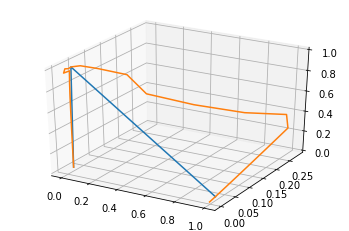

In [0]:
predictions=np.array(predictions)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*subgoals.numpy().T)
ax.plot(*predictions.T)

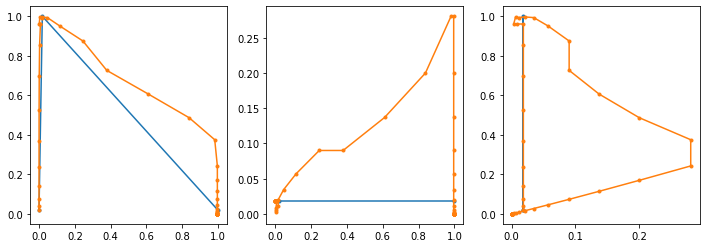

In [0]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
plt.figure(figsize=(12,4))
ax = plt.subplot(131)
ax.plot(subgoals[..., 0], subgoals[..., 2], '.-')

# Plot our predictions
predictions=np.array(predictions)
ax.plot(predictions[..., 0], predictions[..., 2], '.-')

###########
ax = plt.subplot(132)
ax.plot(subgoals[..., 0], subgoals[..., 1], '.-')
ax.plot(predictions[..., 0], predictions[..., 1], '.-')

ax = plt.subplot(133)
ax.plot(subgoals[..., 1], subgoals[..., 2], '.-')
ax.plot(predictions[..., 1], predictions[..., 2], '.-')

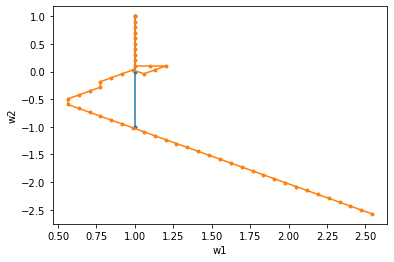

In [0]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

#training_weights = np.array(logger.weights).squeeze()
training_weights = np.array(training_weights).squeeze()
ax.plot(training_weights[..., 0], training_weights[..., 1], '.-')